In [113]:
import pickle
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import seaborn as sns

import olympus
from olympus import __home__
from olympus.datasets import Dataset
from olympus.emulators import Emulator


In [2]:
df = pd.read_csv('expver-3.0_1%1%1%1.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   identifier                918 non-null    object 
 1   fingerprint               918 non-null    object 
 2   outcome                   918 non-null    int64  
 3   organic___0___inchikey    918 non-null    object 
 4   organic___0___inchi       918 non-null    object 
 5   organic___0___chemname    918 non-null    object 
 6   organic___0___molarity    918 non-null    float64
 7   inorganic___0___inchikey  918 non-null    object 
 8   inorganic___0___inchi     918 non-null    object 
 9   inorganic___0___chemname  918 non-null    object 
 10  inorganic___0___molarity  918 non-null    float64
 11  solvent___0___inchikey    918 non-null    object 
 12  solvent___0___inchi       918 non-null    object 
 13  solvent___0___chemname    918 non-null    object 
 14  solvent___

In [38]:
cols_to_check = ['organic___0___chemname', 'inorganic___0___chemname', 'solvent___0___chemname',
                 'acid___0___chemname' ]
for col in cols_to_check:
    print(col)
    print( df[col].unique().tolist() ) 
    print(len(df[col].unique()))
    

organic___0___chemname
['Ethylammonium Iodide', 'Phenethylammonium iodide ', 'Acetamidinium iodide', 'N,N-Diethylpropane-1,3-diammonium iodide', '1,4-Benzene diammonium iodide', '4-Trifluoromethyl-Benzylammonium iodide', '2-Pyrrolidin-1-ium-1-ylethylammonium iodide', 'N,N-Dimethylethane-1,2-diammonium iodide', 'Morpholinium Iodide', 'Cyclohexylmethylammonium iodide', 'Dimethylammonium iodide', 'Diethylammonium iodide', 'Di-isopropylammonium iodide', '4-methoxy-phenethylammonium-iodide', '2,2-dimethylpropane-1,3-diammonium iodide', '2-Thiophenemethylammonium iodide', '4-Methoxy-Phenylammonium iodide']
17
inorganic___0___chemname
['Lead Diiodide']
1
solvent___0___chemname
['Gamma-Butyrolactone', 'Dimethylformamide', 'Dimethyl sulfoxide']
3
acid___0___chemname
['Formic Acid']
1


In [39]:
df['solvent___0___inchikey'].unique()

array(['YEJRWHAVMIAJKC-UHFFFAOYSA-N', 'ZMXDDKWLCZADIW-UHFFFAOYSA-N',
       'IAZDPXIOMUYVGZ-UHFFFAOYSA-N'], dtype=object)

In [40]:
df['solvent___0___chemname'].unique()

array(['Gamma-Butyrolactone', 'Dimethylformamide', 'Dimethyl sulfoxide'],
      dtype=object)

In [41]:
df['solvent___0___chemname'].value_counts()

Gamma-Butyrolactone    456
Dimethylformamide      388
Dimethyl sulfoxide      74
Name: solvent___0___chemname, dtype: int64

In [42]:
# df['solvent___0___molarity'].unique()

In [43]:
cols_to_keep = [
    # parameters
    'organic___0___chemname', 'organic___0___molarity',
    'solvent___0___chemname', 'solvent___0___molarity', 
    'inorganic___0___molarity',
    'acid___0___molarity',
    'alpha_vial_volume',
    'beta_vial_volume',
    'reaction_time',
    'reaction_temperature',
    # objectives
    'outcome',
]

cont_params = ['organic___0___molarity', 'solvent___0___molarity', 
              'inorganic___0___molarity', 'acid___0___molarity', 'alpha_vial_volume',
              'beta_vial_volume', 'reaction_time', 'reaction_temperature']

obj_map  = {1:'clear_solution', 2:'fine_powder', 3:'small_crystallites', 4:'large_crystallites'}

In [44]:
df = df[cols_to_keep]
print(df.shape)
df.head()

(918, 11)


,organic___0___chemname,organic___0___molarity,solvent___0___chemname,solvent___0___molarity,inorganic___0___molarity,acid___0___molarity,alpha_vial_volume,beta_vial_volume,reaction_time,reaction_temperature,outcome
0,Ethylammonium Iodide,1.414806,Gamma-Butyrolactone,7.826123,0.647652,6.116412,0.000650,0.001,21600.0,85.0,4
1,Ethylammonium Iodide,1.715131,Gamma-Butyrolactone,7.427794,0.782321,5.990171,0.000646,0.001,21600.0,85.0,4
2,Ethylammonium Iodide,1.757650,Gamma-Butyrolactone,8.118530,0.424064,5.198623,0.000622,0.001,21600.0,85.0,1
3,Ethylammonium Iodide,1.165508,Gamma-Butyrolactone,7.227637,0.317379,8.547507,0.000738,0.001,21600.0,85.0,4
4,Ethylammonium Iodide,1.598292,Gamma-Butyrolactone,6.588398,0.649051,8.225520,0.000725,0.001,21600.0,85.0,4


organic___0___molarity
min :  0.0143426290821092
max :  7.393553108829781
solvent___0___molarity
min :  1.0556935090440152
max :  12.795580963868504
inorganic___0___molarity
min :  0.0
max :  2.261151669730513
acid___0___molarity
min :  0.0
max :  22.42276776015642
alpha_vial_volume
min :  0.000149
max :  0.000744
beta_vial_volume
min :  0.0006
max :  0.001
reaction_time
min :  21600.0
max :  64800.0
reaction_temperature
min :  70.0
max :  85.0


/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/riley/Software/anaconda3/envs/olympus/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

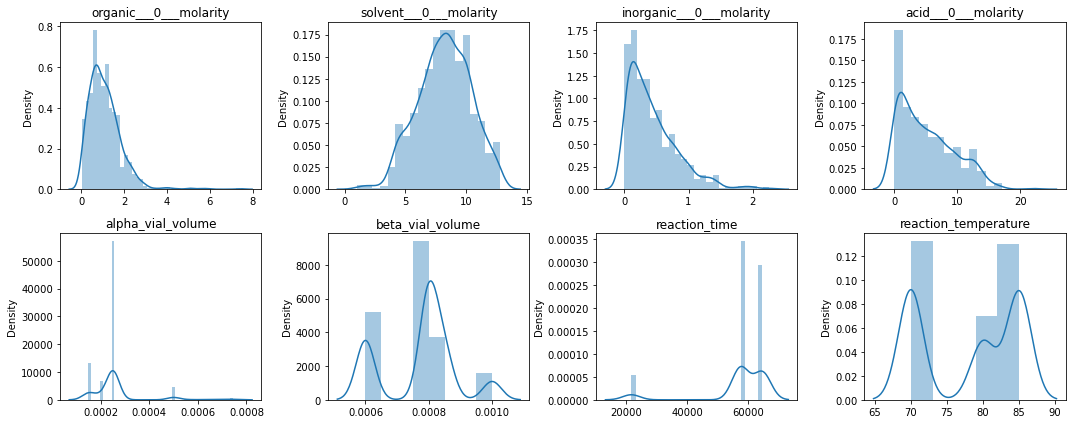

In [45]:
fig, axes= plt.subplots(2,4, figsize=(15, 6))
axes = axes.flatten()

for ix,  param in enumerate(cont_params):
    
    print(param)
    values = df[param].values
    print('min : ', np.amin(values))
    print('max : ', np.amax(values))
    
    sns.distplot(values, ax=axes[ix])
    axes[ix].set_title(param)

plt.tight_layout()

In [47]:
# map crystal score integer to strings
ints = df['outcome'].values
strs = []
for int_ in ints:
    strs.append(obj_map[int_])

In [48]:
df['outcome']=strs

In [49]:
df

,organic___0___chemname,organic___0___molarity,solvent___0___chemname,solvent___0___molarity,inorganic___0___molarity,acid___0___molarity,alpha_vial_volume,beta_vial_volume,reaction_time,reaction_temperature,outcome
0,Ethylammonium Iodide,1.414806,Gamma-Butyrolactone,7.826123,0.647652,6.116412,0.000650,0.0010,21600.0,85.0,large_crystallites
1,Ethylammonium Iodide,1.715131,Gamma-Butyrolactone,7.427794,0.782321,5.990171,0.000646,0.0010,21600.0,85.0,large_crystallites
2,Ethylammonium Iodide,1.757650,Gamma-Butyrolactone,8.118530,0.424064,5.198623,0.000622,0.0010,21600.0,85.0,clear_solution
3,Ethylammonium Iodide,1.165508,Gamma-Butyrolactone,7.227637,0.317379,8.547507,0.000738,0.0010,21600.0,85.0,large_crystallites
4,Ethylammonium Iodide,1.598292,Gamma-Butyrolactone,6.588398,0.649051,8.225520,0.000725,0.0010,21600.0,85.0,large_crystallites
...,...,...,...,...,...,...,...,...,...,...,...
913,Phenethylammonium iodide,2.337736,Dimethyl sulfoxide,6.479453,0.034328,4.770802,0.000250,0.0008,21600.0,85.0,clear_solution
914,Phenethylammonium iodide,1.509677,Dimethyl sulfoxide,6.189231,0.022886,8.693461,0.000250,0.0008,21600.0,85.0,clear_solution
915,Phenethylammonium iodide,2.440708,Dimethyl sulfoxide,6.594527,0.783831,2.650445,0.000250,0.0008,21600.0,85.0,clear_solution
916,Phenethylammonium iodide,1.128722,Dimethyl sulfoxide,9.709896,0.245040,3.167863,0.000251,0.0008,21600.0,85.0,clear_solution


In [51]:
df = df.replace({'Phenethylammonium iodide ': 'Phenethylammonium iodide'})

In [52]:
df.to_csv('../data.csv', index=False)

In [54]:
# parse descriptors
# covention: cat var name, option name, desc name, desc value

desc = pd.read_csv('expver-3.0_1%1%1%1-features.csv')
print(desc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 91 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   outcome                                                 918 non-null    int64  
 1   organic___0___molarity                                  918 non-null    float64
 2   organic___0____feat__accsitecount_std                   918 non-null    float64
 3   organic___0____feat__aliphaticatomcount_std             918 non-null    float64
 4   organic___0____feat__aliphaticringcount_std             918 non-null    float64
 5   organic___0____feat__aromaticatomcount_std              918 non-null    float64
 6   organic___0____feat__aromaticringcount_std              918 non-null    float64
 7   organic___0____feat__asa+_std                           918 non-null    float64
 8   organic___0____feat__asa-_std           

In [60]:
desc.columns

Index(['outcome', 'organic___0___molarity',
       'organic___0____feat__accsitecount_std',
       'organic___0____feat__aliphaticatomcount_std',
       'organic___0____feat__aliphaticringcount_std',
       'organic___0____feat__aromaticatomcount_std',
       'organic___0____feat__aromaticringcount_std',
       'organic___0____feat__asa+_std', 'organic___0____feat__asa-_std',
       'organic___0____feat__asa_std', 'organic___0____feat__asah_std',
       'organic___0____feat__asap_std', 'organic___0____feat__asavdwp_std',
       'organic___0____feat__atomcount_c_std',
       'organic___0____feat__atomcount_n_std',
       'organic___0____feat__avgpol_std',
       'organic___0____feat__balabanindex_std',
       'organic___0____feat__bondcount_std',
       'organic___0____feat__carboaliphaticringcount_std',
       'organic___0____feat__carboaromaticringcount_std',
       'organic___0____feat__carboringcount_std',
       'organic___0____feat__chainatomcount_std',
       'organic___0____feat

In [68]:
organic_desc_names = [
       'accsitecount_std',
       'aliphaticatomcount_std',
       'aliphaticringcount_std',
       'aromaticatomcount_std',
       'aromaticringcount_std',
       'asa+_std', 'asa-_std',
       'asa_std', 'asah_std',
       'asap_std', 'asavdwp_std',
       'atomcount_c_std',
       'atomcount_n_std',
       'avgpol_std',
       'balabanindex_std',
       'bondcount_std',
       'carboaliphaticringcount_std',
       'carboaromaticringcount_std',
       'carboringcount_std',
       'chainatomcount_std',
       'cyclomaticnumber_std',
       'donsitecount_std',
       'fr_amidine', 'fr_halogen',
       'fr_nh0', 'fr_nh1',
       'fr_nh2', 'fr_piperzine',
       'fr_pyridine', 'fr_quatn',
       'hacceptorcount_std',
       'hdonorcount_std',
       'heteroaliphaticringcount_std',
       'heteroaromaticringcount_std',
       'hyperwienerindex_std',
       'largestringsize_std',
       'maximalprojectionarea_std',
       'maximalprojectionradius_std',
       'maximalprojectionsize_std',
       'minimalprojectionarea_std',
       'minimalprojectionradius_std',
       'minimalprojectionsize_std',
       'molpol_std',
       'organoammoniummolecularweight_std',
       'protpsa_std',
       'refractivity_std',
       'ringatomcount_std',
       'rotatablebondcount_std',
       'saltmolecularweight',
       'smallestringsize_std',
       'vanderwaalsvolume_std',
       'wienerindex_std',
       'wienerpolarity_std',
]

solvent_desc_names = [
       'asavdwp',
       'avgpol', 'hacceptorcount',
       'hansentriple_volume_amount',
       'hansentriple_deltad_amount',
       'hansentriple_deltah_amount',
       'hansentriple_deltap_amount',
       'hansentriple_deltat_amount',
       'maximalprojectionsize',
       'minimalprojectionsize',
       'refractivity',
       'solventmolecularweight',
       'vanderwaalsvolume'
]

print(len(organic_desc_names))
print(len(solvent_desc_names))

53
13


In [69]:
desc_csv = {'var_name': [], 'option_name': [], 'desc_name': [], 'desc_val': []}

for ix in range(df.shape[0]):
    exp_row = df.iloc[ix, :].to_dict()
    desc_row = desc.iloc[ix, :].to_dict()
    
    # organic descs 
    for desc_name in organic_desc_names:
        option_name = exp_row['organic___0___chemname']
        desc_val = desc_row[f'organic___0____feat__{desc_name}']
        
        desc_csv['var_name'].append('organic')
        desc_csv['option_name'].append(option_name)
        desc_csv['desc_name'].append(desc_name)
        desc_csv['desc_val'].append(desc_val)
        
    # solvent descs 
    for desc_name in solvent_desc_names:
        option_name = exp_row['solvent___0___chemname']
        desc_val = desc_row[f'solvent___0____feat__{desc_name}']

        desc_csv['var_name'].append('solvent')
        desc_csv['option_name'].append(option_name)
        desc_csv['desc_name'].append(desc_name)
        desc_csv['desc_val'].append(desc_val)

    
    
    

In [72]:
desc_olymp = pd.DataFrame(desc_csv)
print(desc_olymp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60588 entries, 0 to 60587
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   var_name     60588 non-null  object 
 1   option_name  60588 non-null  object 
 2   desc_name    60588 non-null  object 
 3   desc_val     60588 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.8+ MB
None


In [73]:
desc_olymp.head()

,var_name,option_name,desc_name,desc_val
0,organic,Ethylammonium Iodide,accsitecount_std,0.0
1,organic,Ethylammonium Iodide,aliphaticatomcount_std,3.0
2,organic,Ethylammonium Iodide,aliphaticringcount_std,0.0
3,organic,Ethylammonium Iodide,aromaticatomcount_std,0.0
4,organic,Ethylammonium Iodide,aromaticringcount_std,0.0


In [74]:
desc_olymp = desc_olymp.drop_duplicates()
desc_olymp

,var_name,option_name,desc_name,desc_val
0,organic,Ethylammonium Iodide,accsitecount_std,0.000
1,organic,Ethylammonium Iodide,aliphaticatomcount_std,3.000
2,organic,Ethylammonium Iodide,aliphaticringcount_std,0.000
3,organic,Ethylammonium Iodide,aromaticatomcount_std,0.000
4,organic,Ethylammonium Iodide,aromaticringcount_std,0.000
...,...,...,...,...
44796,organic,4-Methoxy-Phenylammonium iodide,saltmolecularweight,251.067
44797,organic,4-Methoxy-Phenylammonium iodide,smallestringsize_std,6.000
44798,organic,4-Methoxy-Phenylammonium iodide,vanderwaalsvolume_std,122.320
44799,organic,4-Methoxy-Phenylammonium iodide,wienerindex_std,90.000


In [75]:
desc_olymp.to_csv('../descriptors.csv', index=False)

In [80]:
df['organic___0___chemname'].unique().tolist()

['Ethylammonium Iodide',
 'Phenethylammonium iodide',
 'Acetamidinium iodide',
 'N,N-Diethylpropane-1,3-diammonium iodide',
 '1,4-Benzene diammonium iodide',
 '4-Trifluoromethyl-Benzylammonium iodide',
 '2-Pyrrolidin-1-ium-1-ylethylammonium iodide',
 'N,N-Dimethylethane-1,2-diammonium iodide',
 'Morpholinium Iodide',
 'Cyclohexylmethylammonium iodide',
 'Dimethylammonium iodide',
 'Diethylammonium iodide',
 'Di-isopropylammonium iodide',
 '4-methoxy-phenethylammonium-iodide',
 '2,2-dimethylpropane-1,3-diammonium iodide',
 '2-Thiophenemethylammonium iodide',
 '4-Methoxy-Phenylammonium iodide']

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# attempt to load dataset from olympus
from olympus.datasets import Dataset

In [6]:
dataset = Dataset(kind='vapdiff_crystal')
dataset.task

'ordinal'

In [7]:
print(dataset.data.shape)
dataset.data.head()

(918, 11)


,organic,organic_molarity,solvent,solvent_molarity,inorganic_molarity,acid_molarity,alpha_vial_volume,beta_vial_volume,reaction_time,reaction_temperature,crystal_score
0,Ethylammonium Iodide,1.414806,Gamma-Butyrolactone,7.826123,0.647652,6.116412,0.00065,0.001,21600.0,85.0,large_crystallites
1,Ethylammonium Iodide,1.715131,Gamma-Butyrolactone,7.427794,0.782321,5.990171,0.000646,0.001,21600.0,85.0,large_crystallites
2,Ethylammonium Iodide,1.75765,Gamma-Butyrolactone,8.11853,0.424064,5.198623,0.000622,0.001,21600.0,85.0,clear_solution
3,Ethylammonium Iodide,1.165508,Gamma-Butyrolactone,7.227637,0.317379,8.547507,0.000738,0.001,21600.0,85.0,large_crystallites
4,Ethylammonium Iodide,1.598292,Gamma-Butyrolactone,6.588398,0.649051,8.22552,0.000725,0.001,21600.0,85.0,large_crystallites


In [8]:
dataset.features.head()

,organic,organic_molarity,solvent,solvent_molarity,inorganic_molarity,acid_molarity,alpha_vial_volume,beta_vial_volume,reaction_time,reaction_temperature
0,Ethylammonium Iodide,1.414806,Gamma-Butyrolactone,7.826123,0.647652,6.116412,0.00065,0.001,21600.0,85.0
1,Ethylammonium Iodide,1.715131,Gamma-Butyrolactone,7.427794,0.782321,5.990171,0.000646,0.001,21600.0,85.0
2,Ethylammonium Iodide,1.75765,Gamma-Butyrolactone,8.11853,0.424064,5.198623,0.000622,0.001,21600.0,85.0
3,Ethylammonium Iodide,1.165508,Gamma-Butyrolactone,7.227637,0.317379,8.547507,0.000738,0.001,21600.0,85.0
4,Ethylammonium Iodide,1.598292,Gamma-Butyrolactone,6.588398,0.649051,8.22552,0.000725,0.001,21600.0,85.0


In [9]:
dataset.targets.head()

,crystal_score
0,large_crystallites
1,large_crystallites
2,clear_solution
3,large_crystallites
4,large_crystallites


In [10]:
dataset.descriptors

,param,option,name,value
0,organic,Ethylammonium Iodide,accsitecount_std,0.0
1,organic,Ethylammonium Iodide,aliphaticatomcount_std,3.0
2,organic,Ethylammonium Iodide,aliphaticringcount_std,0.0
3,organic,Ethylammonium Iodide,aromaticatomcount_std,0.0
4,organic,Ethylammonium Iodide,aromaticringcount_std,0.0
...,...,...,...,...
935,organic,4-Methoxy-Phenylammonium iodide,saltmolecularweight,251.067
936,organic,4-Methoxy-Phenylammonium iodide,smallestringsize_std,6.0
937,organic,4-Methoxy-Phenylammonium iodide,vanderwaalsvolume_std,122.32
938,organic,4-Methoxy-Phenylammonium iodide,wienerindex_std,90.0


### Parameter space constraints

In [8]:
df = pd.read_csv('expver-4.0_1%1%1%1.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   identifier                    918 non-null    object 
 1   fingerprint                   918 non-null    object 
 2   outcome                       918 non-null    int64  
 3   organic___0___inchikey        918 non-null    object 
 4   organic___0___inchi           918 non-null    object 
 5   organic___0___chemname        918 non-null    object 
 6   organic___0___molarity        918 non-null    float64
 7   organic___0___molarity_max    918 non-null    float64
 8   inorganic___0___inchikey      918 non-null    object 
 9   inorganic___0___inchi         918 non-null    object 
 10  inorganic___0___chemname      918 non-null    object 
 11  inorganic___0___molarity      918 non-null    float64
 12  inorganic___0___molarity_max  918 non-null    float64
 13  solve

In [9]:
df.head()

,identifier,fingerprint,outcome,organic___0___inchikey,organic___0___inchi,organic___0___chemname,organic___0___molarity,organic___0___molarity_max,inorganic___0___inchikey,inorganic___0___inchi,...,acid___0___inchikey,acid___0___inchi,acid___0___chemname,acid___0___molarity,acid___0___molarity_max,alpha_vial_volume,beta_vial_volume,reaction_time,reaction_temperature,antisolvent_identity
0,2019-05-30T20_58_22.535516+00_00_LBL_A1,1%1%1%1,4,XFYICZOIWSBQSK-UHFFFAOYSA-N,"InChI=1S/C2H7N.HI/c1-2-3;/h2-3H2,1H3;1H",Ethylammonium Iodide,1.414806,11.86941,RQQRAHKHDFPBMC-UHFFFAOYSA-L,InChI=1S/2HI.Pb/h2*1H;/q;;+2/p-2,...,BDAGIHXWWSANSR-UHFFFAOYSA-N,"InChI=1S/CH2O2/c2-1-3/h1H,(H,2,3)",Formic Acid,6.116412,26.504454,0.000650,0.001,21600.0,85.0,YMWUJEATGCHHMB-UHFFFAOYSA-N
1,2019-05-30T20_58_22.535516+00_00_LBL_C1,1%1%1%1,4,XFYICZOIWSBQSK-UHFFFAOYSA-N,"InChI=1S/C2H7N.HI/c1-2-3;/h2-3H2,1H3;1H",Ethylammonium Iodide,1.715131,11.86941,RQQRAHKHDFPBMC-UHFFFAOYSA-L,InChI=1S/2HI.Pb/h2*1H;/q;;+2/p-2,...,BDAGIHXWWSANSR-UHFFFAOYSA-N,"InChI=1S/CH2O2/c2-1-3/h1H,(H,2,3)",Formic Acid,5.990171,26.504454,0.000646,0.001,21600.0,85.0,YMWUJEATGCHHMB-UHFFFAOYSA-N
2,2019-05-30T20_58_22.535516+00_00_LBL_E1,1%1%1%1,1,XFYICZOIWSBQSK-UHFFFAOYSA-N,"InChI=1S/C2H7N.HI/c1-2-3;/h2-3H2,1H3;1H",Ethylammonium Iodide,1.757650,11.86941,RQQRAHKHDFPBMC-UHFFFAOYSA-L,InChI=1S/2HI.Pb/h2*1H;/q;;+2/p-2,...,BDAGIHXWWSANSR-UHFFFAOYSA-N,"InChI=1S/CH2O2/c2-1-3/h1H,(H,2,3)",Formic Acid,5.198623,26.504454,0.000622,0.001,21600.0,85.0,YMWUJEATGCHHMB-UHFFFAOYSA-N
3,2019-05-30T20_58_22.535516+00_00_LBL_G1,1%1%1%1,4,XFYICZOIWSBQSK-UHFFFAOYSA-N,"InChI=1S/C2H7N.HI/c1-2-3;/h2-3H2,1H3;1H",Ethylammonium Iodide,1.165508,11.86941,RQQRAHKHDFPBMC-UHFFFAOYSA-L,InChI=1S/2HI.Pb/h2*1H;/q;;+2/p-2,...,BDAGIHXWWSANSR-UHFFFAOYSA-N,"InChI=1S/CH2O2/c2-1-3/h1H,(H,2,3)",Formic Acid,8.547507,26.504454,0.000738,0.001,21600.0,85.0,YMWUJEATGCHHMB-UHFFFAOYSA-N
4,2019-05-30T20_58_22.535516+00_00_LBL_A3,1%1%1%1,4,XFYICZOIWSBQSK-UHFFFAOYSA-N,"InChI=1S/C2H7N.HI/c1-2-3;/h2-3H2,1H3;1H",Ethylammonium Iodide,1.598292,11.86941,RQQRAHKHDFPBMC-UHFFFAOYSA-L,InChI=1S/2HI.Pb/h2*1H;/q;;+2/p-2,...,BDAGIHXWWSANSR-UHFFFAOYSA-N,"InChI=1S/CH2O2/c2-1-3/h1H,(H,2,3)",Formic Acid,8.225520,26.504454,0.000725,0.001,21600.0,85.0,YMWUJEATGCHHMB-UHFFFAOYSA-N


In [10]:
types_ = ['organic', 'inorganic', 'solvent', 'acid']

organic_molarity_max = {}
inorganic_molarity_max = {}
solvent_molarity_max = {}
acid_molarity_max = {}

organic_map = {
    'Ethylammonium Iodide': 'Ethylammonium Iodide',
    'Phenethylammonium iodide ' : 'Phenethylammonium iodide',
    'Acetamidinium iodide': 'Acetamidinium iodide',
    'N,N-Diethylpropane-1,3-diammonium iodide': 'NN-Diethylpropane-13-diammonium iodide',
    '1,4-Benzene diammonium iodide': '14-Benzene diammonium iodide',
    '4-Trifluoromethyl-Benzylammonium iodide': '4-Trifluoromethyl-Benzylammonium iodide',
    '2-Pyrrolidin-1-ium-1-ylethylammonium iodide': '2-Pyrrolidin-1-ium-1-ylethylammonium iodide',
    'N,N-Dimethylethane-1,2-diammonium iodide': 'NN-Dimethylethane-12-diammonium iodide',
    'Morpholinium Iodide': 'Morpholinium Iodide',
    'Cyclohexylmethylammonium iodide': 'Cyclohexylmethylammonium iodide',
    'Dimethylammonium iodide': 'Dimethylammonium iodide',
    'Diethylammonium iodide': 'Diethylammonium iodide',
    'Di-isopropylammonium iodide': 'Di-isopropylammonium iodide',
    '4-methoxy-phenethylammonium-iodide': '4-methoxy-phenethylammonium-iodide',
    '2,2-dimethylpropane-1,3-diammonium iodide': '22-dimethylpropane-13-diammonium iodide',
    '2-Thiophenemethylammonium iodide': '2-Thiophenemethylammonium iodide',
    '4-Methoxy-Phenylammonium iodide': '4-Methoxy-Phenylammonium iodide',
}


organic_options = list(df['organic___0___inchikey'].unique())
for opt in organic_options:
    mol_max = df.loc[df['organic___0___inchikey']==opt]['organic___0___molarity_max'].to_numpy()[0]
    chem_name = df.loc[df['organic___0___inchikey']==opt]['organic___0___chemname'].to_numpy()[0]
    chem_name = organic_map[chem_name]
    organic_molarity_max[chem_name] = mol_max

inorganic_options = list(df['inorganic___0___inchikey'].unique())
for opt in inorganic_options:
    mol_max = df.loc[df['inorganic___0___inchikey']==opt]['inorganic___0___molarity_max'].to_numpy()[0]
    chem_name = df.loc[df['inorganic___0___inchikey']==opt]['inorganic___0___chemname'].to_numpy()[0]
    inorganic_molarity_max[chem_name] = mol_max

solvent_options = list(df['solvent___0___inchikey'].unique())
for opt in solvent_options:
    mol_max = df.loc[df['solvent___0___inchikey']==opt]['solvent___0___molarity_max'].to_numpy()[0]
    chem_name = df.loc[df['solvent___0___inchikey']==opt]['solvent___0___chemname'].to_numpy()[0]
    solvent_molarity_max[chem_name] = mol_max

acid_options = list(df['acid___0___inchikey'].unique())
for opt in acid_options:
    mol_max = df.loc[df['acid___0___inchikey']==opt]['acid___0___molarity_max'].to_numpy()[0]
    chem_name = df.loc[df['acid___0___inchikey']==opt]['acid___0___chemname'].to_numpy()[0]
    acid_molarity_max[chem_name] = mol_max

In [11]:
pickle.dump(
    {'organic_molarity_max': organic_molarity_max, 'inorganic_molarity_max': inorganic_molarity_max, 
     'solvent_molarity_max': solvent_molarity_max, 'acid_molarity_max': acid_molarity_max},
    open('max_molarity_constraints.pkl', 'wb')
)

In [12]:
acid_molarity_max

{'Formic Acid': 26.50445361720617}

In [13]:
# convex hull
ch = pd.read_csv('convexhull.csv')
print(ch.info())
print(ch.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BAMDIFIROXTEEM-UHFFFAOYSA-N  149 non-null    float64
 1   BDAGIHXWWSANSR-UHFFFAOYSA-N  149 non-null    float64
 2   GGYGJCFIYJVWIP-UHFFFAOYSA-N  149 non-null    float64
 3   IAZDPXIOMUYVGZ-UHFFFAOYSA-N  149 non-null    float64
 4   JMXLWMIFDJCGBV-UHFFFAOYSA-N  149 non-null    float64
 5   KFXBDBPOGBBVMC-UHFFFAOYSA-N  149 non-null    float64
 6   LLWRXQXPJMPHLR-UHFFFAOYSA-N  149 non-null    float64
 7   NXRUEVJQMBGVAT-UHFFFAOYSA-N  149 non-null    float64
 8   ODZKCFHAXXFIQC-UHFFFAOYSA-N  149 non-null    float64
 9   PBGZCCFVBVEIAS-UHFFFAOYSA-N  149 non-null    float64
 10  QNNYEDWTOZODAS-UHFFFAOYSA-N  149 non-null    float64
 11  QRFXELVDJSDWHX-UHFFFAOYSA-N  149 non-null    float64
 12  QTWVKKIQSUTRSU-UHFFFAOYSA-N  149 non-null    float64
 13  QZCGFUVVXNFSLE-UHFFF

In [14]:
ch_cols = ch.columns.to_list()

In [15]:
rename_names = {}
drop_cols = []

for col in ch_cols:
    if col in organic_options:
        chem_name = df.loc[df['organic___0___inchikey']==col]['organic___0___chemname'].to_numpy()[0]
        chem_name = organic_map[chem_name]
        rename_names[col] = chem_name
    elif col in inorganic_options:
        chem_name = df.loc[df['inorganic___0___inchikey']==col]['inorganic___0___chemname'].to_numpy()[0]
        rename_names[col] = chem_name
    elif col in solvent_options:
        chem_name = df.loc[df['solvent___0___inchikey']==col]['solvent___0___chemname'].to_numpy()[0]
        rename_names[col] = chem_name
    elif col in acid_options:
        chem_name = df.loc[df['acid___0___inchikey']==col]['acid___0___chemname'].to_numpy()[0]
        rename_names[col] = chem_name
    else:
        drop_cols.append(col)

In [16]:

ch = ch.drop(columns=drop_cols)

['KFXBDBPOGBBVMC-UHFFFAOYSA-N', 'LLWRXQXPJMPHLR-UHFFFAOYSA-N', 'QZCGFUVVXNFSLE-UHFFFAOYSA-N', 'XLYOFNOQVPJJNP-UHFFFAOYSA-N']


In [17]:
ch = ch.rename(columns=rename_names)

In [18]:
ch

,NN-Dimethylethane-12-diammonium iodide,Formic Acid,Acetamidinium iodide,Dimethyl sulfoxide,Dimethylammonium iodide,NN-Diethylpropane-13-diammonium iodide,22-dimethylpropane-13-diammonium iodide,Di-isopropylammonium iodide,4-methoxy-phenethylammonium-iodide,4-Methoxy-Phenylammonium iodide,...,14-Benzene diammonium iodide,4-Trifluoromethyl-Benzylammonium iodide,Phenethylammonium iodide,2-Pyrrolidin-1-ium-1-ylethylammonium iodide,Morpholinium Iodide,Ethylammonium Iodide,Gamma-Butyrolactone,Diethylammonium iodide,Cyclohexylmethylammonium iodide,Dimethylformamide
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,12.913817
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.504821,0.000000,0.000000,6.456908
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.209087,3.077779,0.000000,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.950659,0.000000,1.947498,0.000000
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13.009641,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1.361837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,9.235736
145,1.527012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,8.796568
146,1.937648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,8.965851
147,2.030248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,8.777179


In [21]:
organic = "Ethylammonium Iodide"
inorganic = "Lead Diiodide"
solvent = "Gamma-Butyrolactone"
acid = "Formic Acid"

exps = df[(df['organic___0___chemname']==organic)&\
          (df['inorganic___0___chemname']==inorganic)&\
          (df['solvent___0___chemname']==solvent)&\
          (df['acid___0___chemname']==acid)
         ]
print(exps.shape)

(24, 28)


In [89]:
res = exps['outcome'].tolist()
organic_molarity = exps['organic___0___molarity'].tolist()
inorganic_molarity = exps['inorganic___0___molarity'].tolist()
solvent_molarity = exps['solvent___0___molarity'].tolist()
acid_molarity = exps['acid___0___molarity'].tolist()
alpha_volume = exps['alpha_vial_volume'].tolist()

In [90]:
exp_idx = 0

# should pass
target_molarities = {
    organic: organic_molarity[exp_idx],
    inorganic: inorganic_molarity[exp_idx],
    solvent: solvent_molarity[exp_idx],
    acid: acid_molarity[exp_idx]
}
print(target_molarities)

# should fail
# target_molarities = {
#     organic: 2.1,
#     inorganic: 0.01,
#     solvent: 10.02,
#     acid: 8.92
# }

alpha_volume = alpha_volume[exp_idx]

{'Ethylammonium Iodide': 1.4148057318267522, 'Lead Diiodide': 0.6476518625530959, 'Gamma-Butyrolactone': 7.82612293426468, 'Formic Acid': 6.116412373201425}


In [41]:
def backward_check(target_molarities, alpha_volume, df_hull):
    ''' solve volume values as an LP using gurobi 
    
    target_molarities: dict[str, float]
    
    '''
    
    chemnames = [str(c) for c in df_hull.columns]
    assert set(chemnames).issuperset(set(target_molarities.keys()))
    target_molarities_padded = np.zeros(len(df_hull.columns))
    
    for i, chemname in enumerate(chemnames):
        try:
            target_molarities_padded[i] = target_molarities[chemname]
        except KeyError:
            continue
    
    n_ss, n_chem = df_hull.shape
    
    # init gurobi model, suppress output
    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('LogToConsole', 0)
        env.start()
        with gp.Model(env=env) as m:

            v = []
            for i in range(n_ss):
                v_i = m.addVar(lb=0., name=str(i))  # add var
                v.append(v_i)
                m.addConstr(v_i >= 0., name=str(i))

            m.addConstr(sum(v) == alpha_volume, name='volume_sum')
            for j in range(n_chem):
                c = 0.
                for i in range(n_ss):
                    c += v[i] * df_hull.values[i][j]
                m.addConstr(c == alpha_volume * target_molarities_padded[j], name=chemnames[j])

            # objective function
            objective = 1

            m.setObjective(objective, GRB.MINIMIZE)
            m.optimize()

            try:
                sol = [v.x for v in m.getVars()]
                #logger.info("BACKWORD PASSED")
                print('BACKWARD CHECK PASSED')
                return True
            except AttributeError:
                #logger.critical("BACKWORD FAILED")
                print('BACKWARD CHECK FAILED')
                return False
    
    

In [42]:
backward_check(target_molarities, alpha_volume, ch)

BACKWARD CHECK FAILED


False

In [45]:
ch.to_csv('convex_hull_chemnames.csv', index=False)

### Testing constraints for the `vapdiff_crystal` dataset

In [65]:
file = f'{__home__}/datasets/dataset_vapdiff_crystal/'
import sys
sys.path.insert(0, file)

In [66]:
import importlib

In [75]:
module = __import__('constraints')

In [77]:
dir(module)

['GRB',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__home__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 'backward_check',
 'df_hull',
 'gp',
 'known_constraints',
 'max_mol_constr',
 'pd',
 'pickle']

In [129]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
d = Dataset(kind='vapdiff_crystal')

here


In [87]:
d.constraints_module.known_constraints()

<function constraints.known_constraints(param_vec)>

In [96]:
exps.iloc[0, :]

identifier                      2019-05-30T20_58_22.535516+00_00_LBL_A1
fingerprint                                                     1%1%1%1
outcome                                                               4
organic___0___inchikey                      XFYICZOIWSBQSK-UHFFFAOYSA-N
organic___0___inchi             InChI=1S/C2H7N.HI/c1-2-3;/h2-3H2,1H3;1H
organic___0___chemname                             Ethylammonium Iodide
organic___0___molarity                                         1.414806
organic___0___molarity_max                                     11.86941
inorganic___0___inchikey                    RQQRAHKHDFPBMC-UHFFFAOYSA-L
inorganic___0___inchi                  InChI=1S/2HI.Pb/h2*1H;/q;;+2/p-2
inorganic___0___chemname                                  Lead Diiodide
inorganic___0___molarity                                       0.647652
inorganic___0___molarity_max                                  13.361966
solvent___0___inchikey                      YEJRWHAVMIAJKC-UHFFF

In [144]:
test_param_vec = olympus.objects.ParameterVector().from_dict(
    {
        'organic': "Ethylammonium Iodide",
        'organic_molarity': 10.414806,
        'solvent': 'Gamma-Butyrolactone',
        'solvent_molarity': 7.826123,
        'inorganic_molarity': 0.647652,
        'acid_molarity': 6.116412,
        'alpha_vial_volume': 0.00065,
        'beta_vial_volume': 0.001,
        'reaction_time': 21600.,
        'reaction_temperature': 85.0,
    }
)

In [145]:
# d.constraints_module.known_constraints(test_param_vec)

In [146]:
# d = Dataset(kind='suzuki_i')

In [149]:
em = Emulator(dataset='vapdiff_crystal', model='BayesNeuralNet')

[INFO] Loading emulator using a BayesNeuralNet model for the dataset vapdiff_crystal...


In [150]:
em.run(test_param_vec, return_paramvector=True)

[ParamVector(crystal_score = clear_solution)]